# Clasificación de textos mediante combinación de clasificadores, diseñando uno de ellos

La clasificación de textos es un proceso mediante el cual se asigna una categoría específica a un texto determinado entre varias opciones disponibles. Este proceso es fundamental en el análisis de datos textuales y tiene numerosas aplicaciones prácticas.

En esta práctica se va a aplicar a reviews de Tripadvisor, clasificándolas en positivas, neutrales o negativas, es decir, vamos a realizar análisis de sentimientos. Para ello vamos a combinar varios clasificadores, cada uno de ellos hace sus predicciones, y con ellas y la entrada de texto inicial que se les proporciona a cada uno obtendremos la predicción final mediante un ensemble.

Además uno de los clasificadores va a ser diseñado por nosotros, mediante un transformer cuya arquitectura vamos a definir, y le vamos a añadir al modelo características adicionales. Por un lado vamos a tener el transformer customizado partiendo de un modelo base DistilBert, y por otra un extractor de rasgos, un TfidfVectorizer. La salida de ambos se concatena y mediante un clasificador se realizan las predicciones. Vamos a optimizar este modelo añadiendo inputs de bolsas de palabras positivas y negativas para mejorar la tasa de acierto y conseguir mejorar el modelo propuesto por el profesor.




## Importación de librerías y funciones a utilizar

In [ ]:
# reset environment
%reset -f

import numpy as np

# para establecer caminos al guardar y leer archivos
import os

# para cargar datos y realizar pre-procesamiento básico
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

# para pre-procesamiento del texto y extraer característicass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import EnglishStemmer
from sklearn import preprocessing

# para construir pipelines
from sklearn.pipeline import Pipeline, FeatureUnion

# algoritmos de clasificación
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# para evaluar los modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# para guardar el modelo
import pickle
import tensorflow as tf
from transformers.modeling_tf_utils import keras

# para visualizar el modelo
from IPython.core.display import display

# algoritmos de clasificación, tokenizadores, etc.
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertMainLayer
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig, TextClassificationPipeline


print('Done!')

Done!


In [ ]:
# MODELO CUSTOMIZADO CON PALABRAS POSITIVAS

# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs_cus_pos(cfg, data, pos_words):
  # obtener ids y máscaras para el conjunto de entrenamiento
  # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato,
  encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])


  # obtener representación tf-idf de cada instancia
  tfidf = cfg['vectorizer'].transform(data)
  tfidf_t = tf.convert_to_tensor(tfidf.toarray(), dtype='int32')
  num_samples_data, num_features_data = tfidf_t.shape

  # obtener representación palabras positivas de cada instancia
  posi_input = cfg['vectorizer'].transform(pos_words)
  num_samples_pos, num_features_pos = posi_input.shape
  padded_pos_words = np.zeros((num_samples_data, num_features_data))
  padded_pos_words[:num_samples_pos, :num_features_pos] = posi_input.toarray()
  posi_input_t = tf.convert_to_tensor(padded_pos_words, dtype='int32')


  # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
  # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf')
  # son utilizados como llaves en los diccionarios que representan las entradas al modelo
  inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'tfidf': tfidf_t,
            'posi_words': posi_input_t
           }

  return inputs


# función auxiliar para realizar predicciones con el modelo
def predict_model_cus_pos(model, cfg, data, pos_words, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs_cus_pos(cfg, data, pos_words)
  scores = model.predict(inputs)

  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    #res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}
    res = {f'scores_{pref}_{cls}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res

# -----------------------------------------------------------------------------------------------------------------------
# MODELO CUSTOMIZADO CON PALABRAS POSITIVAS Y NEGATIVAS

# función auxiliar para obtener tensores de entrada al modelo a partir del texto
def get_model_inputs_cus(cfg, data, pos_words, neg_words):
  # obtener ids y máscaras para el conjunto de entrenamiento
  # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato,
  encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])


  # obtener representación tf-idf de cada instancia
  tfidf = cfg['vectorizer'].transform(data)
  tfidf_t = tf.convert_to_tensor(tfidf.toarray(), dtype='int32')
  num_samples_data, num_features_data = tfidf_t.shape

  # obtener representación palabras positivas de cada instancia
  posi_input = cfg['vectorizer'].transform(pos_words)
  num_samples_pos, num_features_pos = posi_input.shape
  padded_pos_words = np.zeros((num_samples_data, num_features_data))
  padded_pos_words[:num_samples_pos, :num_features_pos] = posi_input.toarray()
  posi_input_t = tf.convert_to_tensor(padded_pos_words, dtype='int32')

  # obtener representación palabras negativas de cada instancia
  nega_input = cfg['vectorizer'].transform(neg_words)
  num_samples_neg, num_features_neg = nega_input.shape
  padded_neg_words = np.zeros((num_samples_data, num_features_data))
  padded_neg_words[:num_samples_neg, :num_features_neg] = nega_input.toarray()
  nega_input_t = tf.convert_to_tensor(padded_neg_words, dtype='int32')

  # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
  # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf')
  # son utilizados como llaves en los diccionarios que representan las entradas al modelo
  inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'tfidf': tfidf_t,
            'posi_words': posi_input_t,
            'nega_words': nega_input_t
           }

  return inputs


# función auxiliar para realizar predicciones con el modelo
def predict_model_cus(model, cfg, data, pos_words, neg_words, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs_cus(cfg, data, pos_words, neg_words)
  scores = model.predict(inputs)

  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    #res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}
    res = {f'scores_{pref}_{cls}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# -----------------------------------------------------------------------------------------------------------------------
# MODELO PIPELINE PARA CLASIFICACIÓN DE TEXTOS

# listado de stopwords
stop_words=['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves',
            'he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their',
            'theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are',
            'was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an',
            'the','and','but','if','or','because','as','until','while','of','at','by','for','with','about',
            'against','between','into','through','during','before','after','above','below','to','from','up',
            'down','in','out','on','off','over','under','again','further','then','once','here','there','when',
            'where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor',
            'not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'ever']

# función auxiliar. Se utiliza al obtener la representación mediante TF-IDF del texto pues en este caso
# se removerán las stop_words y se considerarán los "stem" en lugar de las palabras
def english_stemmer(sentence):
  stemmer = EnglishStemmer()
  analyzer = CountVectorizer(binary=False, analyzer='word', stop_words=stop_words, ngram_range=(1, 1)).build_analyzer()
  return (stemmer.stem(word) for word in analyzer(sentence))

# función auxiliar para realizar predicciones con el modelo 1
def predict_model01(model, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  scores = None
  labels = model.predict(data)

  if hasattr(model, 'predict_proba'):
    scores = model.predict_proba(data)

  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  #res = {f'scores_{pref}_{cls.lower()}':score for cls, score in zip(model.classes_, [col for col in scores.T])}
  res = {f'scores_{pref}_{cls}':score for cls, score in zip(model.classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))

  return res

# -----------------------------------------------------------------------------------------------------------------------
# MODELO FINE-TUNNED TRANSFORMER

  # función auxiliar para obtener tensores de entrada al modelo 3 a partir del texto
def get_model_inputs03(cfg, data):
    # obtener ids y máscaras para el conjunto de entrenamiento
    # no es necesario convertir a tensores porque la salida del tokenizador se encuentra en este formato,
    encodings = cfg['tokenizer'](data, truncation=True, padding='max_length', max_length=cfg['max_length'], return_tensors=cfg['framework'])

    # formatear los datos (tensores) de entrada de acuerdo con las opciones permitidas por TensorFlow
    # los nombres de las capas de Input creadas al construir el modelo ('input_ids', 'attention_mask', 'tfidf')
    # son utilizados como llaves en los diccionarios que representan las entradas al modelo
    inputs = {'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
            }
    return inputs


# función auxiliar para realizar predicciones con el modelo 3
def predict_model03(model, cfg, data, pref='m'):
  """
  data: list of the text to predict
  pref: identificador para las columnas (labels_[pref], scores_[pref]_[class 1], etc.)
  """
  res = {}
  inputs = get_model_inputs03(cfg, data)
  scores = model.predict(inputs)['logits']  # la salida de este modelo es TFSequenceClassifierOutput, debe tomarse el valor asociado a la llave 'logits'

  # empaquetar scores dentro de un diccionario que contiene labels, scores clase 1, scores clase 2, .... El nombre de la clase se normaliza a lowercase
  if cfg['num_labels']==1: # si es clasificación binaria, este modelo devuelve solo 1 score por instancia
    res = {f'scores_{pref}': scores[:,0]}
  else:
    #res = {f'scores_{pref}_{cls.lower()}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}
    res = {f'scores_{pref}_{cls}': score for cls, score in zip(cfg['label_binarizer'].classes_, [col for col in scores.T])}

  # añadir datos relativos a la predicción
  labels = cfg['label_binarizer'].inverse_transform(scores)
  res[f'labels_{pref}'] = labels

  # convertir a dataframe ordenando las columnas primero el label y luego los scores por clase, las clases ordenadas alfabéticamente
  res = pd.DataFrame(res, columns=sorted(list(res.keys())))
  return res


# -----------------------------------------------------------------------------------------------------------------------

# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'y':0.95, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()

print('Done!')

Done!


Palabras positivas y negativas

In [ ]:
pos_words = [
    "amazing",
    "awesome",
    "excellent",
    "fantastic",
    "Wonderful",
    "great",
    "outstanding",
    "superb",
    "terrific",
    "fabulous",
    "incredible",
    "phenomenal",
    "splendid",
    "marvelous",
    "extraordinary",
    "brilliant",
    "stellar",
    "remarkable",
    "magnificent",
    "perfect",
    "Delightful",
    "joyful",
    "blissful",
    "happy",
    "cheerful",
    "uplifting",
    "satisfying",
    "thrilling",
    "enjoyable",
    "impressive",
    "exhilarating",
    "refreshing",
    "heartwarming",
    "wondrous",
    "Excellent",
    "wonderful",
    "lovely",
    "beautiful",
    "charming",
    "pleasant",
    "delightful",
    "gorgeous",
    "adorable",
    "lovable",
    "fine",
    "cool",
    "sweet",
    "Awesome",
    "breathtaking"
]

In [ ]:
neg_words = [
    "terrible",
    "horrible",
    "awful",
    "bad",
    "poor",
    "disappointing",
    "disgusting",
    "unpleasant",
    "unfortunate",
    "miserable",
    "mediocre",
    "subpar",
    "lousy",
    "dreadful",
    "abysmal",
    "atrocious",
    "inferior",
    "unsatisfactory",
    "disastrous",
    "shameful",
    "unacceptable",
    "offensive",
    "vile",
    "repulsive",
    "repugnant",
    "grim",
    "depressing",
    "gloomy",
    "dreary",
    "sorrowful",
    "dismal",
    "Unfortunate",
    "deplorable",
    "despicable",
    "horrendous",
    "negative",
    "Unpleasant",
    "ugly",
    "unfavorable",
    "disheartening",
    "heartbreaking",
    "distressing",
    "tragic",
    "difficult",
    "discomforting",
    "undesirable",
    "Unlucky",
    "Unfavorable",
    "unwanted",
    "disturbing"
]

## Datos


El primer paso es importar los datos y realizar un preprocesamiento de estos.

In [ ]:
import pandas as pd

def load_data_tripadvisor(path:str):
    '''
    Funcion que procesa la base de datos a partir de la ruta en que se encuentra
    '''
    df = pd.read_csv(path, sep='\t', index_col=0, names=['text', 'score'])
    df['Opinion'] = df['text'].str.split('_PROS_Liked_—_').str.get(0)
    df['PROS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(0).str.replace('_', ' ')
    df['CONS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(1).str.replace('_', ' ')
    df['Sentiment'] = df.apply(lambda row: get_score_tripadvisor(row),axis=1)
    return df


def get_score_tripadvisor(row):
    '''
    Funcion para reducir el abanico de puntuaciones a predecir.
    0: Negativa
    1: Neutral

    2: Positiva
    '''
    score = int(row['score'])
    if score < 3:
        return 0
    elif score < 4:
        return 1
    else:
        return 2

In [ ]:
path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/01-SA-Pipeline/sample_data/ejercicio_tripadvisor.csv'

data = load_data_tripadvisor(path)

Vamos a visualizar los datos una vez los hemos cargados. Lo que vemos es que se trata de datos desbalanceados, pues tenemos muchas más instancias de la clase 2. Para entrenar el modelo necesitamos nivelar estas cantidades para que el modelo sea capaz de clasificar correctamente sin sesgos.

In [ ]:
text_col = 'text'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col])
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()


print('Done!')

Total de instancias -> 10508
Distribución de clases:
    0: 0.113
    1: 0.1
    2: 0.787
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Good for the money  Having read the reviews - well it is Rome and you get what you pay for  Nice place and good location - remember that it is at the TOP of the Spanish steps - so if you prefer not to make the walk at the end of the day - pay more and stay at another hotel at the BOTTOM of the steps The staff were great and the bathroom was nice  The room was fine for what we paid Not recommended if you are looking for a  romantic  getaway  but for my sister and I - it was fine for all the tourist things we did  _PROS_Liked_—_Location_and_Price _CONS_Disliked_—_Beds
Categoría del comentario -> 2


Done!


Dividimos el conjunto de datos en dos bloques: entrenamiento y validación para evaluar el modelo

In [ ]:
# obtener conjuntos de entrenamiento (90%) y validación (10%)
seed = 0  # fijar random_state para reproducibilidad
train0, val0 = train_test_split(data, test_size=.1, stratify=data[class_col], random_state=seed)
print('Done!')

Done!


Una vez tenemos el conjunto de entrenamiento y el de validación separados podemos utilizar estrategias para el balanceo de datos. Vamos a emplear Under Sampling, que es recortar las instancias de cada clase al número de la categoría minoritaria.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0,sampling_strategy='auto')
train0 = train0.sample(frac=1)
data_undersamp = rus.fit_resample(train0,train0[class_col])
train, train[class_col]=data_undersamp

In [ ]:
categories = sorted(train[class_col].unique(), reverse=False)
hist= Counter(train[class_col])

for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(train[class_col]), 3)}')

print(f'Categorías -> {categories}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

    0: 0.333
    1: 0.333
    2: 0.333
Categorías -> [0, 1, 2]


Vemos que los datos de entrenamiento están igualados para las tres clases, tenemos 947 de cada una. Vamos a hacer lo mismo para el conjunto de entrenamiento, en este caso tendremos 105 para cada una.

In [ ]:
val = val0.sample(frac=1)
data_val_undersamp = rus.fit_resample(val0,val0[class_col])
val, val[class_col]=data_val_undersamp

In [ ]:
categories = sorted(val[class_col].unique(), reverse=False)
hist= Counter(val[class_col])

for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(val[class_col]), 3)}')

print(f'Categorías -> {categories}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

    0: 0.333
    1: 0.333
    2: 0.333
Categorías -> [0, 1, 2]


## Modelo Customizado

En primer lugar vamos a considerar en nuestro modelo customizado el input de los textos a clasificar y una bolsa de palabras positivas para reforzar el sentimiento positivo. Luego probaremos introduciendo también palabras negativas y veremos si conseguimos mejores resultados. Además, podemos incorporar estas listas de palabras en distintos puntos del transformer y tener estructuras diferentes, vamos a ver tres formas distintas y elegiremos el que mejor resultados obtenga.

### Solo palabras positivas


#### Opción 1 (Concatenación inicial con salida del transformer y salida de tf_idf)

In [ ]:
def get_model_graph_01_pos(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32')

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32')

  # crear variable que representará las palabras positivas
  positive_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='posi_words', dtype='float32')

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features = keras.layers.concatenate([transformes_cls_embedding, input_tfidf, positive_words], name='concatenate')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier')(features)

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout')(pre_classifier)

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer)

  return input_ids, input_masks, input_tfidf, positive_words, classifier

print('Done!')

Done!


**Configuración del modelo**

In [ ]:
def configure_model_01_pos(input_ids, input_masks, input_tfidf, positive_words, classifier):
  # definir algoritmo de optimización
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  # crear el modelo
  model = keras.Model(inputs=[input_ids, input_masks, input_tfidf, positive_words], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

  return model

print('Done!')

Done!


**Instanciar modelo**

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 3  # cambiar este número según el número de clases
#cfg['number_of_positive_words'] = 50
cfg['number_of_positive_words'] = 2841

print('Done!')

Done!


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 distilbert (TFDistilBertMa  ((None, 512, 768),           6636288   ['input_ids[0][0]',           
 inLayer)                    )                            0          'attention_mask[0][0]']      
                                                                                  

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



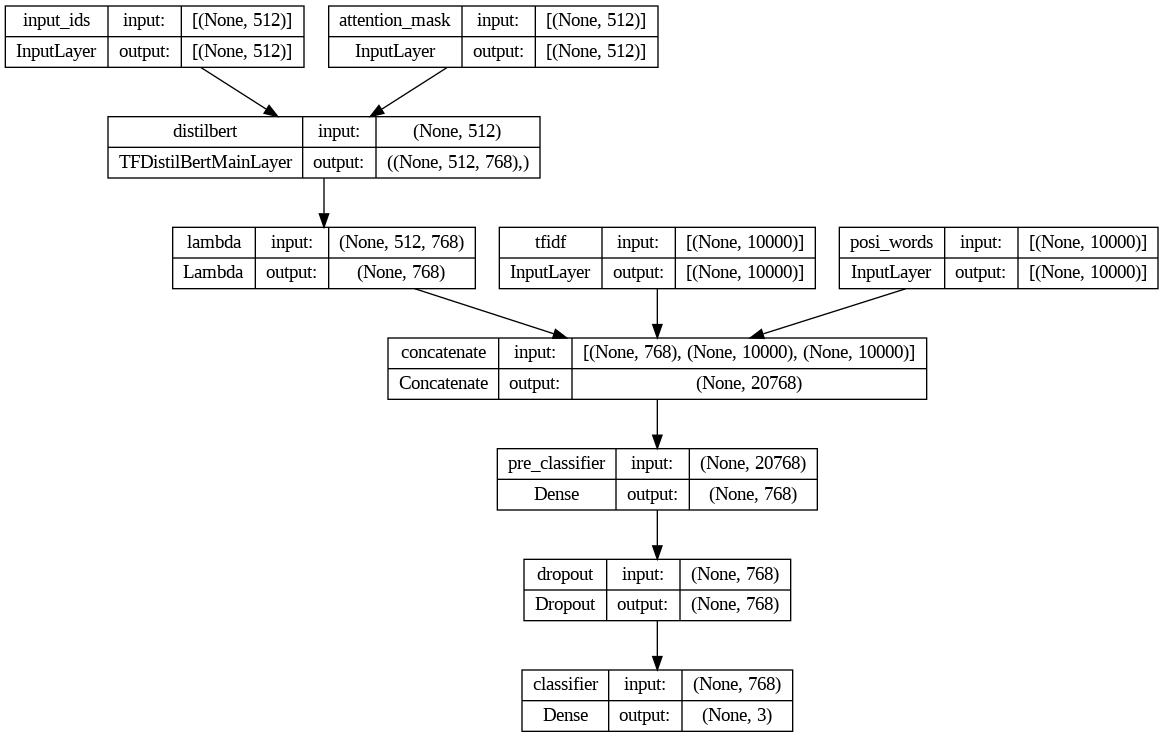

Done!


In [ ]:
input_ids, input_masks, input_tfidf, positive_words, classifier = get_model_graph_01_pos(cfg)
model = configure_model_01_pos(input_ids, input_masks, input_tfidf, positive_words, classifier)

# imprimir sumario del modelo
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

**Instanciar tokenizador, tf-idf vectorizer, etc.**

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Done!


**Pre-procesamiento**

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs_cus_pos(cfg, train[text_col].to_list(), pos_words)
val_inputs = get_model_inputs_cus_pos(cfg, val[text_col].to_list(), pos_words)

print('Done!')

Done!


**Entrenamiento**

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')

    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, initial_epoch=epoch_current, epochs=epoch_to, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_weights(cfg['trained_model_name'], save_format="tf")

print('Done!')

Training model, epochs 1 - 1
178/178 [==============================] - 209s 943ms/step - loss: 0.6816 - categorical_accuracy: 0.6920 - val_loss: 0.5649 - val_categorical_accuracy: 0.7460
Done!


**Predicciones**

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred_01_pos = predict_model_cus_pos(model, cfg, data[text_col].to_list(), pos_words, pref='m')

evaluate_model(true_labels, m_pred_01_pos['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 59s 621ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       947
           1       0.76      0.82      0.79       947
           2       0.86      0.94      0.90       947

    accuracy                           0.85      2841
   macro avg       0.86      0.85      0.85      2841
weighted avg       0.86      0.85      0.85      2841

Accuracy -> 84.86%



Done!


In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred_01_pos_val = predict_model_cus_pos(model, cfg, data[text_col].to_list(), pos_words, pref='m')

evaluate_model(true_labels, m_pred_01_pos_val['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 592ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       105
           1       0.61      0.70      0.65       105
           2       0.80      0.86      0.83       105

    accuracy                           0.75       315
   macro avg       0.76      0.75      0.75       315
weighted avg       0.76      0.75      0.75       315

Accuracy -> 74.60%



Done!


Al añadir la bolsa de palabras positivas vemos que la clasificación para las reviews positivas mejora notablemente, de hecho se ve favorecida y es la que mejores resultados tiene. En cuanto a las negativas y neutrales muestran un porcentaje de acierto similar. Si nos fijamos en las neutrales mal clasificadas, vemos que la mayor parte se han clasificado como positivas, pues estas opiniones también dan lugar a palabras positivas y puede generar este efecto a la hora de clasificar.

#### Opción 2 (Concatenación de palabras tras el pre-classifier)

In [ ]:
def get_model_graph_02_pos(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32')

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32')

  # crear variable que representará las palabras positivas
  positive_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='posi_words', dtype='float32')

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features1 = keras.layers.concatenate([transformes_cls_embedding, input_tfidf], name='concatenate1')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier')(features1)

  # concatenar salida del pre_classifier con el vector de palabras.
  features2 = keras.layers.concatenate([pre_classifier, positive_words], name='concatenate2')

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout')(features2)

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer)

  return input_ids, input_masks, input_tfidf, positive_words, classifier

print('Done!')

Done!


**Configuración del modelo**

In [ ]:
def configure_model_02_pos(input_ids, input_masks, input_tfidf, positive_words, classifier):
  # definir algoritmo de optimización
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  # crear el modelo
  model = keras.Model(inputs=[input_ids, input_masks, input_tfidf, positive_words], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

  return model

print('Done!')

Done!


**Instanciar modelo**

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 3  # cambiar este número según el número de clases
#cfg['number_of_positive_words'] = 50
cfg['number_of_positive_words'] = 2841

print('Done!')

Done!


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 distilbert (TFDistilBertMa  ((None, 512, 768),           6636288   ['input_ids[0][0]',           
 inLayer)                    )                            0          'attention_mask[0][0]']      
                                                                                  

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



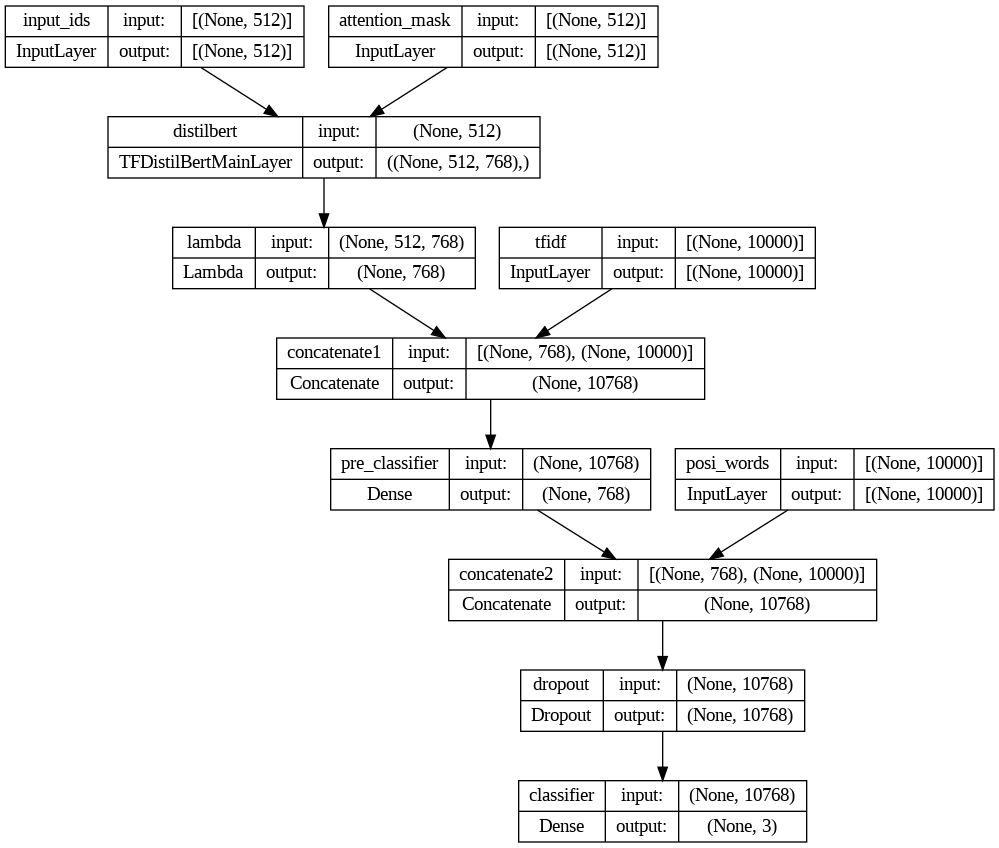

Done!


In [ ]:
input_ids, input_masks, input_tfidf, positive_words, classifier = get_model_graph_02_pos(cfg)
model = configure_model_02_pos(input_ids, input_masks, input_tfidf, positive_words, classifier)

# imprimir sumario del modelo
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

**Instanciar tokenizador, tf-idf vectorizer, etc.**

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


**Pre-procesamiento**

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs_cus_pos(cfg, train[text_col].to_list(), pos_words)
val_inputs = get_model_inputs_cus_pos(cfg, val[text_col].to_list(), pos_words)

print('Done!')

Done!


**Entrenamiento**

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')

    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, initial_epoch=epoch_current, epochs=epoch_to, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_weights(cfg['trained_model_name'], save_format="tf")

print('Done!')

Training model, epochs 1 - 1
178/178 [==============================] - 228s 965ms/step - loss: 0.7454 - categorical_accuracy: 0.6470 - val_loss: 0.5935 - val_categorical_accuracy: 0.7492
Done!


**Predicciones**

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred_02_pos = predict_model_cus_pos(model, cfg, data[text_col].to_list(), pos_words, pref='m')

evaluate_model(true_labels, m_pred_02_pos['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 59s 619ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       947
           1       0.74      0.68      0.71       947
           2       0.93      0.81      0.87       947

    accuracy                           0.81      2841
   macro avg       0.82      0.81      0.81      2841
weighted avg       0.82      0.81      0.81      2841

Accuracy -> 81.17%



Done!


In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred_02_pos_val = predict_model_cus_pos(model, cfg, data[text_col].to_list(), pos_words, pref='m')

evaluate_model(true_labels, m_pred_02_pos_val['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 601ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       105
           1       0.63      0.63      0.63       105
           2       0.92      0.75      0.83       105

    accuracy                           0.75       315
   macro avg       0.76      0.75      0.75       315
weighted avg       0.76      0.75      0.75       315

Accuracy -> 74.92%



Done!


En este caso, que se incorporan las palabras positivas tras el pre-classifier, las reviews que se ven favorecidas son las negativas, y las más perjudicadas las neutrales.

#### Opción 3 (Concatenación de palabras tras un primer pre-classifier y hacer un segundo pre-classifier)

In [ ]:
def get_model_graph_03_pos(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32')

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32')

  # crear variable que representará las palabras positivas
  positive_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='posi_words', dtype='float32')

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features1 = keras.layers.concatenate([transformes_cls_embedding, input_tfidf], name='concatenate1')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier1 = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier1')(features1)

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer1 = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout1')(pre_classifier1)

  features2 = keras.layers.concatenate([dropout_layer1, positive_words], name='concatenate2')

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier2 = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier2')(features2)

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer2 = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout2')(pre_classifier2)

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer2)

  return input_ids, input_masks, input_tfidf, positive_words, classifier

print('Done!')

Done!


**Configuración del modelo**

In [ ]:
def configure_model_03_pos(input_ids, input_masks, input_tfidf, positive_words, classifier):
  # definir algoritmo de optimización
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  # crear el modelo
  model = keras.Model(inputs=[input_ids, input_masks, input_tfidf, positive_words], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

  return model

print('Done!')

Done!


**Instanciar modelo**

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 3  # cambiar este número según el número de clases
#cfg['number_of_positive_words'] = 50
cfg['number_of_positive_words'] = 2841

print('Done!')

Done!


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 distilbert (TFDistilBertMa  ((None, 512, 768),           6636288   ['input_ids[0][0]',           
 inLayer)                    )                            0          'attention_mask[0][0]']      
                                                                                  

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



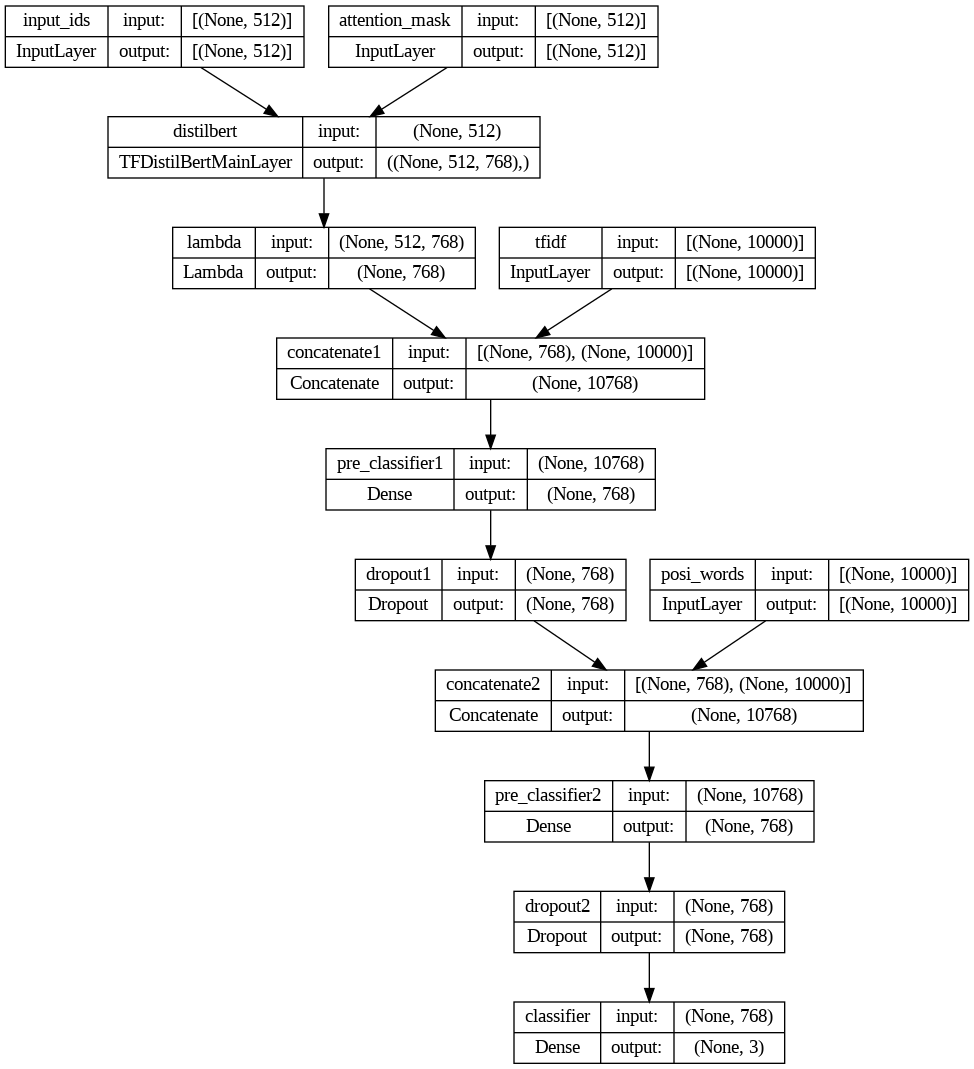

Done!


In [ ]:
input_ids, input_masks, input_tfidf, positive_words, classifier = get_model_graph_03_pos(cfg)
model = configure_model_03_pos(input_ids, input_masks, input_tfidf, positive_words, classifier)

# imprimir sumario del modelo
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

**Instanciar tokenizador, tf-idf vectorizer, etc.**

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


**Pre-procesamiento**

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs_cus_pos(cfg, train[text_col].to_list(), pos_words)
val_inputs = get_model_inputs_cus_pos(cfg, val[text_col].to_list(), pos_words)

print('Done!')

Done!


**Entrenamiento**

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')

    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, initial_epoch=epoch_current, epochs=epoch_to, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_weights(cfg['trained_model_name'], save_format="tf")

print('Done!')

Training model, epochs 1 - 1
178/178 [==============================] - 202s 967ms/step - loss: 0.7231 - categorical_accuracy: 0.6762 - val_loss: 0.5812 - val_categorical_accuracy: 0.7397
Done!


**Predicciones**

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred_03_pos = predict_model_cus_pos(model, cfg, data[text_col].to_list(), pos_words, pref='m')

evaluate_model(true_labels, m_pred_03_pos['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 59s 622ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       947
           1       0.73      0.85      0.79       947
           2       0.89      0.91      0.90       947

    accuracy                           0.84      2841
   macro avg       0.85      0.84      0.84      2841
weighted avg       0.85      0.84      0.84      2841

Accuracy -> 84.30%



Done!


In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred_03_pos_val = predict_model_cus_pos(model, cfg, data[text_col].to_list(), pos_words, pref='m')

evaluate_model(true_labels, m_pred_03_pos_val['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 601ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       105
           1       0.60      0.72      0.66       105
           2       0.83      0.87      0.85       105

    accuracy                           0.74       315
   macro avg       0.76      0.74      0.74       315
weighted avg       0.76      0.74      0.74       315

Accuracy -> 73.97%



Done!


Para este modelo se han considerado dos pre-classifiers, y se han incorporado las palabras positivas entre ambos. Con esta estructura se ven favorecidas las reviews positivas, las neutrales se clasifican un poco peor, pero las negativas se ven perjudicadas.

### Palabras positivas y negativas

#### Opción 1 (Concatenación inicial con salida del transformer y salida de tf_idf)

In [ ]:
def get_model_graph_01_bi(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32')

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32')

  # crear variable que representará las palabras positivas
  positive_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='posi_words', dtype='float32')

  # crear variable que representará las palabras negativas
  negative_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='nega_words', dtype='float32')

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features = keras.layers.concatenate([transformes_cls_embedding, input_tfidf, positive_words, negative_words], name='concatenate')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier')(features)

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout')(pre_classifier)

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer)

  return input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier

print('Done!')

Done!


**Configuración del modelo**

In [ ]:
def configure_model_01_bi(input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier):
  # definir algoritmo de optimización
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  # crear el modelo
  model = keras.Model(inputs=[input_ids, input_masks, input_tfidf, positive_words, negative_words], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

  return model

print('Done!')

Done!


**Instanciar modelo**

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 3  # cambiar este número según el número de clases


print('Done!')

Done!


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 distilbert (TFDistilBertMa  ((None, 512, 768),           6636288   ['input_ids[0][0]',           
 inLayer)                    )                            0          'attention_mask[0][0]']      
                                                                                  

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



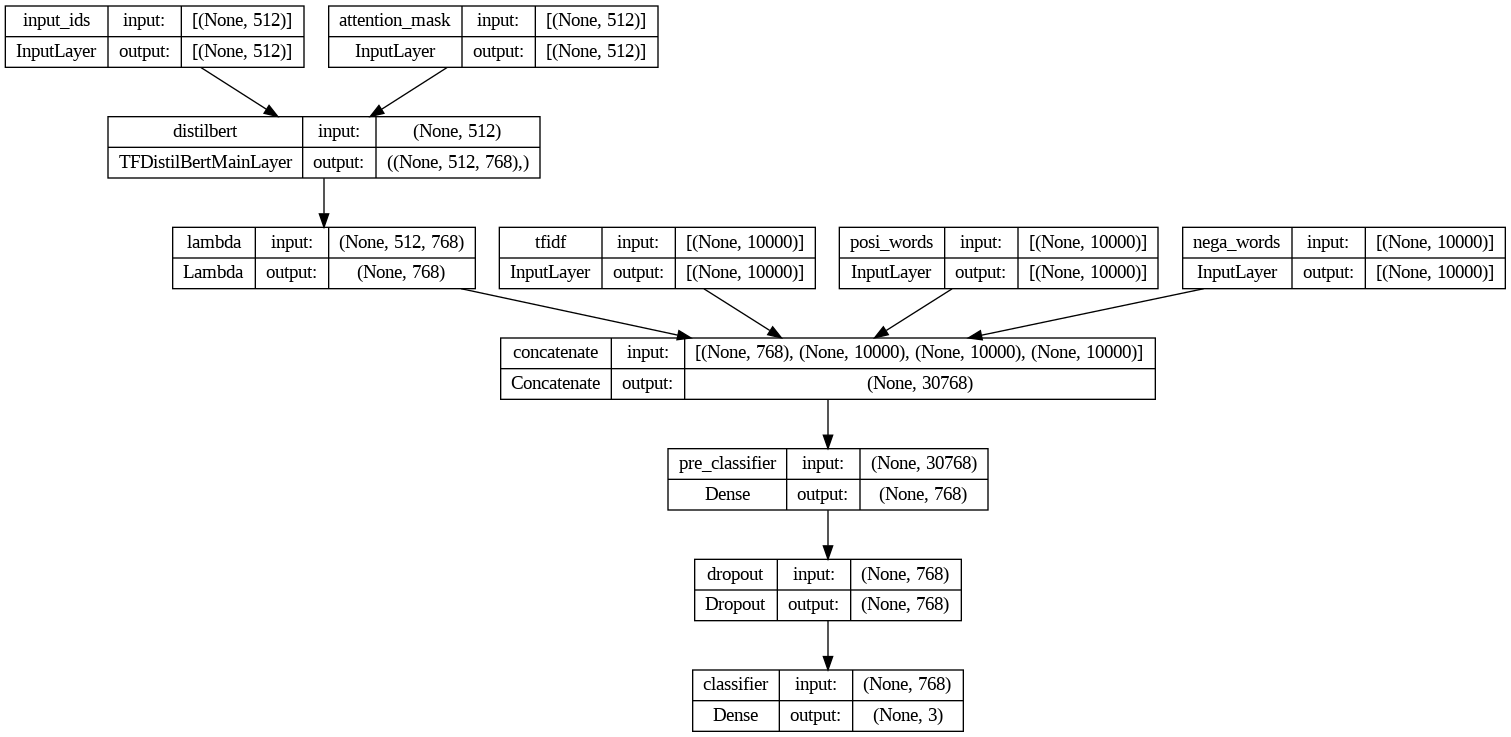

Done!


In [ ]:
input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier = get_model_graph_01_bi(cfg)
model = configure_model_01_bi(input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier)

# imprimir sumario del modelo
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

**Instanciar tokenizador, tf-idf vectorizer, etc.**

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


**Pre-procesamiento**

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs_cus(cfg, train[text_col].to_list(), pos_words, neg_words)
val_inputs = get_model_inputs_cus(cfg, val[text_col].to_list(), pos_words, neg_words)

print('Done!')

Done!


**Entrenamiento**

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')

    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, initial_epoch=epoch_current, epochs=epoch_to, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_weights(cfg['trained_model_name'], save_format="tf")

print('Done!')

Training model, epochs 1 - 1
178/178 [==============================] - 203s 969ms/step - loss: 0.6938 - categorical_accuracy: 0.6899 - val_loss: 0.5548 - val_categorical_accuracy: 0.7429
Done!


**Predicciones**

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred_01_bi = predict_model_cus(model, cfg, data[text_col].to_list(), pos_words, neg_words, pref='m')

evaluate_model(true_labels, m_pred_01_bi['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 59s 619ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       947
           1       0.79      0.82      0.80       947
           2       0.90      0.90      0.90       947

    accuracy                           0.86      2841
   macro avg       0.86      0.86      0.86      2841
weighted avg       0.86      0.86      0.86      2841

Accuracy -> 86.17%



Done!


In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred_01_bi_val = predict_model_cus(model, cfg, data[text_col].to_list(), pos_words, neg_words, pref='m')

evaluate_model(true_labels, m_pred_01_bi_val['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 591ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.78      0.68      0.72       105
           1       0.61      0.69      0.64       105
           2       0.87      0.87      0.87       105

    accuracy                           0.74       315
   macro avg       0.75      0.74      0.74       315
weighted avg       0.75      0.74      0.74       315

Accuracy -> 74.29%



Done!


#### Opción 2 (Concatenación de palabras tras el pre-classifier)

In [ ]:
def get_model_graph_02_bi(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32')

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32')

  # crear variable que representará las palabras positivas
  positive_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='posi_words', dtype='float32')

  # crear variable que representará las palabras negativas
  negative_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='nega_words', dtype='float32')

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features1 = keras.layers.concatenate([transformes_cls_embedding, input_tfidf], name='concatenate1')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier')(features1)

  # concatenar salida del pre_classifier con el vector de palabras.
  features2 = keras.layers.concatenate([pre_classifier, positive_words, negative_words], name='concatenate2')

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout')(features2)

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer)

  return input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier

print('Done!')

Done!


**Configuración del modelo**

In [ ]:
def configure_model_02_bi(input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier):
  # definir algoritmo de optimización
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  # crear el modelo
  model = keras.Model(inputs=[input_ids, input_masks, input_tfidf, positive_words, negative_words], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

  return model

print('Done!')

Done!


**Instanciar modelo**

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 3  # cambiar este número según el número de clases


print('Done!')

Done!


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 distilbert (TFDistilBertMa  ((None, 512, 768),           6636288   ['input_ids[0][0]',           
 inLayer)                    )                            0          'attention_mask[0][0]']      
                                                                                  

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



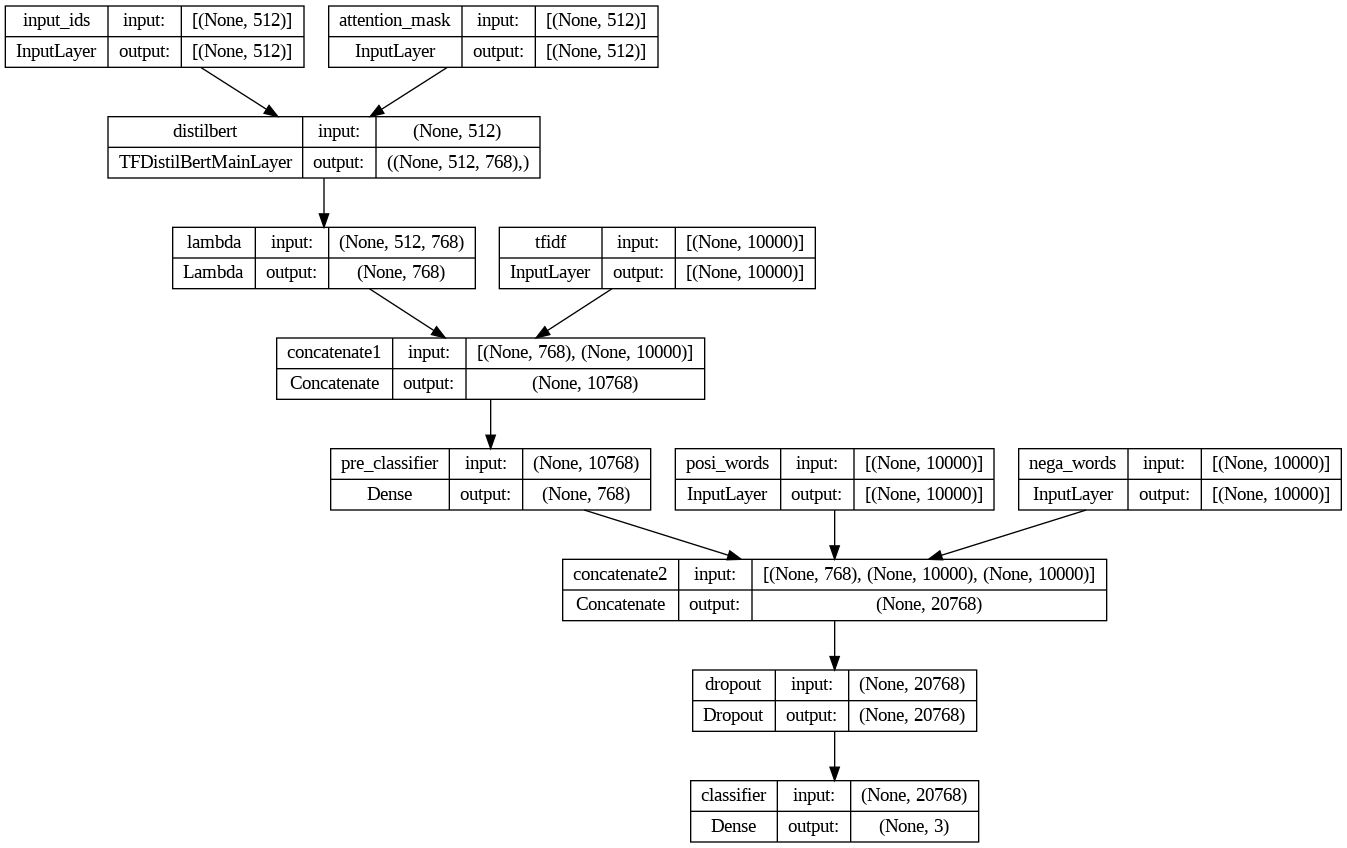

Done!


In [ ]:
input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier = get_model_graph_02_bi(cfg)
model = configure_model_02_bi(input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier)

# imprimir sumario del modelo
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

**Instanciar tokenizador, tf-idf vectorizer, etc.**

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


**Pre-procesamiento**

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs_cus(cfg, train[text_col].to_list(), pos_words, neg_words)
val_inputs = get_model_inputs_cus(cfg, val[text_col].to_list(), pos_words, neg_words)

print('Done!')

Done!


**Entrenamiento**

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')

    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, initial_epoch=epoch_current, epochs=epoch_to, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_weights(cfg['trained_model_name'], save_format="tf")

print('Done!')

Training model, epochs 1 - 1
178/178 [==============================] - 196s 942ms/step - loss: 0.6526 - categorical_accuracy: 0.7078 - val_loss: 0.6018 - val_categorical_accuracy: 0.7524
Done!


**Predicciones**

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred_02_bi = predict_model_cus(model, cfg, data[text_col].to_list(), pos_words, neg_words, pref='m')

evaluate_model(true_labels, m_pred_02_bi['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 59s 620ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       947
           1       0.90      0.54      0.67       947
           2       0.82      0.97      0.89       947

    accuracy                           0.82      2841
   macro avg       0.83      0.82      0.81      2841
weighted avg       0.83      0.82      0.81      2841

Accuracy -> 82.05%



Done!


In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred_02_bi_val = predict_model_cus(model, cfg, data[text_col].to_list(), pos_words, neg_words, pref='m')

evaluate_model(true_labels, m_pred_02_bi_val['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 593ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       105
           1       0.75      0.46      0.57       105
           2       0.77      0.91      0.83       105

    accuracy                           0.75       315
   macro avg       0.75      0.75      0.74       315
weighted avg       0.75      0.75      0.74       315

Accuracy -> 75.24%



Done!


Este modelo es el que mejor accuracy tiene de todos los propuestos, será el que usamos en el ensemble. Las reviews positivas y las negativas se ven beneficiadas, ambas se clasifican bastante bien, sin embargo, las neutrales no tanto. Al tener tanto palabaras positivas como negativas, tiende a clasificar las opiniones en positivas o negativas, y las neutrales se ven reducidas.

#### Opción 3 (Concatenación de palabras tras un primer pre-classifier y hacer un segundo pre-classifier)

In [ ]:
def get_model_graph_03_bi(cfg):
  # cargar capa que representa al transformer, en este caso, TFDistilBertMainLayer
  transformer = TFDistilBertModel.from_pretrained(cfg['transformer_model_name'], return_dict=False).distilbert

  # crear los 'placeholder' correspondientes a las entradas del modelo
  # crear variable que representará las entradas de id para el Transformer
  input_ids = keras.layers.Input(shape=(cfg['max_length'],), name='input_ids', dtype='int32')

  # crear variable que representará las entradas de las máscaras para el Transformer
  input_masks = keras.layers.Input(shape=(cfg['max_length'],), name='attention_mask', dtype='int32')

  # crear variable que representará las entradas correspondientes a los rasgos específicos de dominio.
  input_tfidf = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='tfidf', dtype='float32')

  # crear variable que representará las palabras positivas
  positive_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='posi_words', dtype='float32')

  # crear variable que representará las palabras negativas
  negative_words = keras.layers.Input(shape=(cfg['number_of_additional_features'],), name='nega_words', dtype='float32')

  # indicar que TFDistilBertMainLayer se llama con input_ids e input_mask y capturar su salida, que contiene los embeddings correspondientes a cada token del texto
  # Existen varios criterios (ej. https://arxiv.org/pdf/1908.10084.pdf) sobre qué componenentes utilizar como rasgos,
  # en este caso, tomaremos el embedding correspondiente al token de inicio de texto [CLS] de modo similar a TFDistilBertForSequenceClassification
  transformer_output = transformer(input_ids, attention_mask=input_masks)

  # extraer embedding del token [CLS]
  # la transformación dependerá del tipo de salida del Transformer utilizado, en este caso TFDistilBertMainLayer
  # cuya salida es una tupla de un único elemento, que contiene un arreglo de dimensiones
  # (number_of_instances, number_of_tokens, embedding_dimension), donde el token 0 corresponde al CLS.
  transformes_cls_embedding = keras.layers.Lambda(lambda seq: seq[0][:,0,:], name='lambda')(transformer_output)

  # concatenar embedding del token [CLS] con el vector de rasgos adicionales.
  features1 = keras.layers.concatenate([transformes_cls_embedding, input_tfidf], name='concatenate1')

  # establecer algunos hiper-parámetros del modelo
  initializer_range = 0.02
  hiden_units = 768
  seq_classif_dropout=0.2
  initializer = keras.initializers.TruncatedNormal(stddev=initializer_range)

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier1 = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier1')(features1)

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer1 = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout1')(pre_classifier1)

  features2 = keras.layers.concatenate([dropout_layer1, positive_words, negative_words], name='concatenate2')

  # crear pre_classifier, establecer como su entrada los rasgos concatenados (features).
  pre_classifier2 = keras.layers.Dense(hiden_units, kernel_initializer=initializer, activation='relu', name='pre_classifier2')(features2)

  # crear dropout layer y establecer como su entrada la salida de pre_classifier.
  dropout_layer2 = keras.layers.Dropout(rate=seq_classif_dropout, name='dropout2')(pre_classifier2)

  # crear classifier layer y establecer como su entrada la salida de la capa dropout.
  classifier = keras.layers.Dense(cfg['num_labels'], kernel_initializer=initializer, name='classifier')(dropout_layer2)

  return input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier

print('Done!')

Done!


**Configuración del modelo**

In [ ]:
def configure_model_03_bi(input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier):
  # definir algoritmo de optimización
  optimizer = keras.optimizers.Adam(learning_rate=5e-5)

  # definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
  # y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  # crear el modelo
  model = keras.Model(inputs=[input_ids, input_masks, input_tfidf, positive_words, negative_words], outputs=classifier, name='distilbert-custom') # conectar todos los nodos en un modelo

  # compilar el modelo, indicando otras métricas que se desee monitorear
  # La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
  model.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

  return model

print('Done!')

Done!


**Instanciar modelo**

In [ ]:
cfg = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg['transformer_model_name'] = 'distilbert-base-uncased'
cfg['number_of_additional_features'] = 10000  # específico al problema, en este caso, será la dimensión del vector tf-idf
cfg['num_labels'] = 3  # cambiar este número según el número de clases
#cfg['number_of_positive_words'] = 50
cfg['number_of_positive_words'] = 2841

print('Done!')

Done!


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "distilbert-custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 distilbert (TFDistilBertMa  ((None, 512, 768),           6636288   ['input_ids[0][0]',           
 inLayer)                    )                            0          'attention_mask[0][0]']      
                                                                                  

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning:

The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



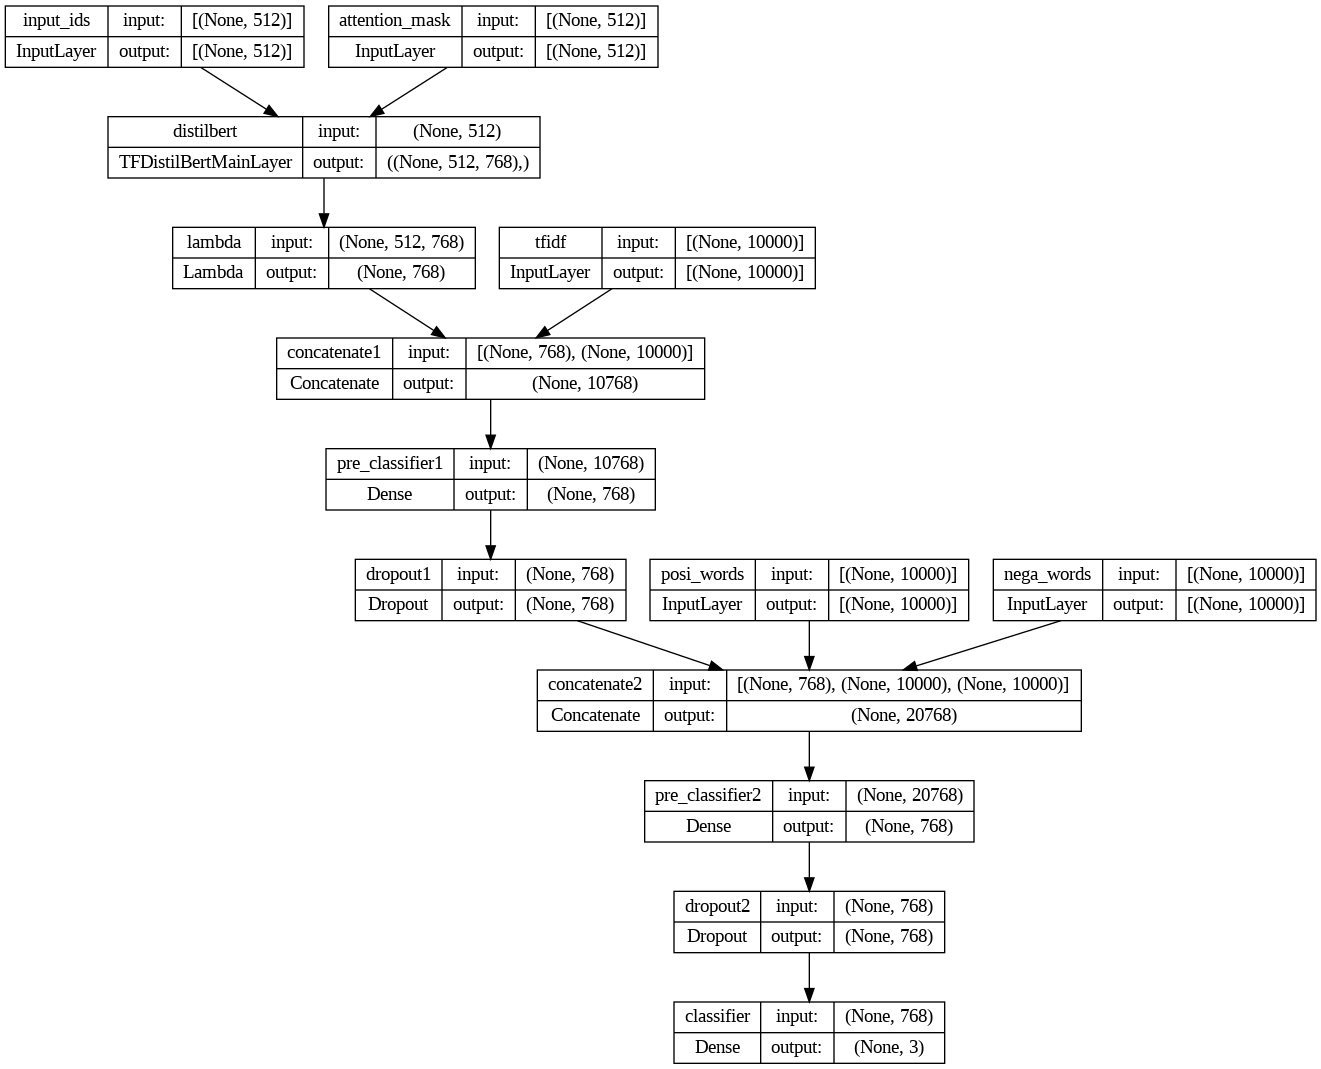

Done!


In [ ]:
input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier = get_model_graph_03_bi(cfg)
model = configure_model_03_bi(input_ids, input_masks, input_tfidf, positive_words, negative_words, classifier)

# imprimir sumario del modelo
model.summary()

# graficar el modelo (opcional)
model_image = tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
display(model_image)

print('Done!')

**Instanciar tokenizador, tf-idf vectorizer, etc.**

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg['transformer_model_name'] )

# instanciar TfidfVectorizer
cfg['vectorizer'] = TfidfVectorizer(stop_words='english', max_features=cfg['number_of_additional_features'])

# instanciar y entrenar LabelBinarizer
cfg['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


**Pre-procesamiento**

In [ ]:
# entrenar TfidfVectorizer
cfg['vectorizer'].fit(train[text_col].to_list())

# guardar TfidfVectorizer entrenado para su posterior uso (codificar nuevos datos).
with open('vectorizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['vectorizer'], f)

# entrenar LabelBinarizer
cfg['label_binarizer'].fit(train[class_col])

# guardar LabelBinarizer para su uso posterior (decodificar las predicciones de nuevos datos)
with open('label_binarizer_reviews.pkl', 'wb') as f:
    pickle.dump(cfg['label_binarizer'], f)

# obtener codificación one-hot
train_blabels = cfg['label_binarizer'].transform(train[class_col])
val_blabes = cfg['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
train_inputs = get_model_inputs_cus(cfg, train[text_col].to_list(), pos_words, neg_words)
val_inputs = get_model_inputs_cus(cfg, val[text_col].to_list(), pos_words, neg_words)

print('Done!')

Done!


**Entrenamiento**

In [ ]:
# configuraciones
cfg['checkpoints_dir'] = 'checkpoints'  # directorio donde se guardarán los checkpoints al entrenar el modelo
cfg['model_name'] = 'distilbert-reviews'  # identificador al guardar los checkpoints
cfg['trained_model_name'] = os.path.join(cfg['checkpoints_dir'], cfg['model_name'])

epochs_max = 1
epochs_to_save = 1 # si epochs_max % epochs_to_save !=0 podrían realizarse iteraciones extras
batch_size = 16

# ciclo de entrenamiento y guardar checkpoints
for epoch_current in range(0, epochs_max, epochs_to_save):
    epoch_from = epoch_current +1
    epoch_to = epoch_current + epochs_to_save
    print(f'Training model, epochs {epoch_from} - {epoch_to}')

    # entrenar el modelo. Opcionalmente, se puede suministrar datos de validación => validation_data=(val_inputs,val_blabels_t )
    model.fit(train_inputs, y=train_blabels_t, initial_epoch=epoch_current, epochs=epoch_to, batch_size=batch_size, validation_data=(val_inputs,val_blabels_t))

    model.save_weights(cfg['trained_model_name'], save_format="tf")

print('Done!')

Training model, epochs 1 - 1
178/178 [==============================] - 207s 947ms/step - loss: 0.7141 - categorical_accuracy: 0.6832 - val_loss: 0.5579 - val_categorical_accuracy: 0.7429
Done!


**Predicciones**

In [ ]:
# predecir los datos de entrenamiento
data = train
true_labels = data[class_col]

m_pred_03_bi = predict_model_cus(model, cfg, data[text_col].to_list(), pos_words, neg_words, pref='m')

evaluate_model(true_labels, m_pred_03_bi['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 63s 625ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       947
           1       0.74      0.87      0.80       947
           2       0.94      0.85      0.89       947

    accuracy                           0.85      2841
   macro avg       0.86      0.85      0.85      2841
weighted avg       0.86      0.85      0.85      2841

Accuracy -> 85.15%



Done!


In [ ]:
# predecir los datos de validación
data = val
true_labels = data[class_col]

m_pred_03_bi_val = predict_model_cus(model, cfg, data[text_col].to_list(), pos_words, neg_words, pref='m')

evaluate_model(true_labels, m_pred_03_bi_val['labels_m'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 594ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       105
           1       0.59      0.75      0.66       105
           2       0.90      0.79      0.84       105

    accuracy                           0.74       315
   macro avg       0.77      0.74      0.75       315
weighted avg       0.77      0.74      0.75       315

Accuracy -> 74.29%



Done!


Al emplear un segundo pre-classifier, el efecto sobre las reviews neutrales se ve reducido. Pero las positivas y negativas no consiguen una clasificación tan buena.

## Modelo 01: Pipeline para clasificación de textos

El primer modelo será un pipeline básico para la clasificación de textos, vamos a tener en cuenta stop words, y las listas de palabras tanto positivas como negativas.

##### Entrenamiento del modelo

In [ ]:
# crear el pipeline
model01 = Pipeline([
            ('features', FeatureUnion([
        ('dataVect', CountVectorizer(analyzer=english_stemmer)),
        ('dataVect_pos', CountVectorizer(vocabulary=pos_words, analyzer='word')),
        ('dataVect_neg', CountVectorizer(vocabulary=neg_words, analyzer='word'))
    ])),
            ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
            ('classifier', SVC(probability=True))
          ])

# entrenar el modelo
model01.fit(train[text_col], train[class_col])

print('Done!')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1380: UserWarning:

Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents



Done!


##### Predicciones

In [ ]:
# predicciones modelo 1
#m01_pred = predict_model01(model01, data[text_col].to_list(), pref='m01')
true_labels = train[class_col]

m01_pred = predict_model01(model01, train[text_col].to_list(), pref='m01')
print(f'\n {m01_pred.head(5)}')

evaluate_model(true_labels, m01_pred['labels_m01'], m01_pred['scores_m01_0'], 'positive')

print('Done!')


    labels_m01  scores_m01_0  scores_m01_1  scores_m01_2
0           0      0.967900      0.030845      0.001256
1           0      0.968369      0.030938      0.000694
2           0      0.920486      0.071010      0.008504
3           0      0.874422      0.121008      0.004570
4           0      0.968532      0.030910      0.000558
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       947
           1       0.99      0.99      0.99       947
           2       0.99      0.99      0.99       947

    accuracy                           0.99      2841
   macro avg       0.99      0.99      0.99      2841
weighted avg       0.99      0.99      0.99      2841

Accuracy -> 99.16%



Done!


In [ ]:
# predecir y evaluar conjunto de validación con el modelo 1
true_labels = val[class_col]

m01_pred_val = predict_model01(model01, val[text_col].to_list(), pref='m01')

evaluate_model(true_labels, m01_pred_val['labels_m01'], m01_pred_val['scores_m01_0'], 'positive')

print('Done!')

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       105
           1       0.61      0.68      0.64       105
           2       0.83      0.75      0.79       105

    accuracy                           0.73       315
   macro avg       0.74      0.73      0.73       315
weighted avg       0.74      0.73      0.73       315

Accuracy -> 73.02%



Done!


## Modelo 03: Fine-tunned Transformer (DistilBERT)

El tercer y último clasificador será un modelo basado en Transformers, entrenado específicamente en nuestros datos. En este caso, es necesario tokenizar y convertir a tensores los datos de acuerdo con los requisitos de Transformers.

En los inputs del modelo añadimos las listas de palabras positivas y negativas junto a los textos para que este modelo también las tenga en cuenta.

##### Configuración del modelo

In [ ]:
# configuraciones
cfg03 = {}  # diccionario para agrupar configuraciones y variables para su posterior uso
cfg03['framework'] = 'tf'  # TensorFlow como framework (por cuestiones del formato en los datos)
cfg03['max_length'] = 512  # máxima longitud de secuencia recomendada por DistilBERT
cfg03['transformer_model_name'] = 'distilbert-base-uncased'
cfg03['num_labels'] = 3  # cambiar este número según el número de clases

print('Done!')

Done!


In [ ]:
# configuraciones
config = DistilBertConfig(num_labels=cfg03['num_labels'], seq_classif_dropout=0.5)

# cargar el modelo pre-entrenado disponible en Transformers
model03 = TFDistilBertForSequenceClassification.from_pretrained(cfg03['transformer_model_name'], config=config)

# finalizar configuración del modelo
# se sugiere revisar documentación para más detalles sobre los diferentes hiper-parámetros
optimizer = keras.optimizers.Adam(learning_rate=5e-5)

# definir función loss. Debe cuidarse que sea coherente con la salida esperada del modelo (vector de num_labels elementos)
# y el formato de los ejemplos (vector one-hot de num_labels componentes para codificar las categorías)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# compilar el modelo, indicando otras métricas que se desee monitorear
# La métrica debe ser apropiada para el tipo de problema (clasificación binaria o multiclase)
model03.compile(optimizer=optimizer, loss=loss, metrics=['categorical_accuracy'])

# imprimir sumario del modelo
model03.summary()

print('Done!')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_133 (Dropout)       multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Done!


##### Instanciar tokenizador, etc.

In [ ]:
# cargar el tokenizador, disponible en Transformers
cfg03['tokenizer'] = DistilBertTokenizer.from_pretrained(cfg03['transformer_model_name'] )

# instanciar y entrenar LabelBinarizer
cfg03['label_binarizer'] = preprocessing.LabelBinarizer() # guardar para su posterior uso al decodificar predicciones

print('Done!')

Done!


##### Pre-procesamiento

In [ ]:
# entrenar LabelBinarizer
cfg03['label_binarizer'].fit(train[class_col])

# obtener codificación one-hot
train_blabels = cfg03['label_binarizer'].transform(train[class_col])
val_blabes = cfg03['label_binarizer'].transform(val[class_col])

# obtener tensores correspondientes
train_blabels_t = tf.convert_to_tensor(train_blabels, dtype='int32')
val_blabels_t = tf.convert_to_tensor(val_blabes, dtype='int32')

# obtener diccionarios representando las entradas del modelo
# Concatenar las palabras positivas con cada texto en train[text_col]
train_with_pos_and_neg = [text + " ".join(pos_words + neg_words) for text in train[text_col].to_list()]
val_with_pos_and_neg = [text + " ".join(pos_words + neg_words) for text in val[text_col].to_list()]

# Obtener inputs del modelo
train_inputs = get_model_inputs03(cfg03, train_with_pos_and_neg)
val_inputs = get_model_inputs03(cfg03, val_with_pos_and_neg)

##### Entrenamiento del modelo

In [ ]:
# configuraciones
epochs_max = 1
batch_size = 16

model03.fit(train_inputs, y=train_blabels_t, initial_epoch=0, epochs=epochs_max, batch_size=batch_size)

print('Done!')

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
178/178 [==============================] - 191s 903ms/step - loss: 0.8109 - categorical_accuracy: 0.6121
Done!


##### Predicciones

In [ ]:
# predicciones modelo 3
#m01_pred = predict_model01(model01, data[text_col].to_list(), pref='m01')
true_labels = train[class_col]

m03_pred = predict_model03(model03, cfg03, train_with_pos_and_neg, pref='m03')

print(f'\n {m03_pred.head(5)}')

evaluate_model(true_labels, m03_pred['labels_m03'])  # notar que en este caso se no suministran los scores

print('Done!')

89/89 [==============================] - 59s 625ms/step

    labels_m03  scores_m03_0  scores_m03_1  scores_m03_2
0           0      2.134538     -0.045726     -1.971096
1           0      2.118915     -0.170379     -1.755414
2           0      1.825521      0.108850     -1.838240
3           1      0.645460      0.767247     -1.366508
4           0      2.084582     -0.016821     -1.869128
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       947
           1       0.80      0.65      0.72       947
           2       0.88      0.90      0.89       947

    accuracy                           0.82      2841
   macro avg       0.82      0.82      0.82      2841
weighted avg       0.82      0.82      0.82      2841

Accuracy -> 82.40%



Done!


In [ ]:
# predecir y evaluar conjunto de validación con el modelo 3
data = val
true_labels = data[class_col]

#m03_pred_val = predict_model03(model03, cfg03, val_with_pos_and_neg, pref='m03')
m03_pred_val = predict_model03(model03, cfg03, val[text_col].to_list(), pref='m03')

evaluate_model(true_labels, m03_pred_val['labels_m03'])  # notar que en este caso se no suministran los scores

print('Done!')

10/10 [==============================] - 6s 595ms/step
==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       105
           1       0.67      0.57      0.62       105
           2       0.86      0.84      0.85       105

    accuracy                           0.76       315
   macro avg       0.75      0.76      0.75       315
weighted avg       0.75      0.76      0.75       315

Accuracy -> 75.56%



Done!


## Construcción del ensemble

Como el stack de clasificadores se construirá de forma manual, es preciso realizar los siguientes pasos:

- utilizar los modelos base para predecir las instancias del conjunto de entrenamiento. En este caso en lugar de la categoría, recuperaremos su probabilidad o scores calculado por el clasificador. Notar que cuando se trata de probabilidades, tendremos información redundante ya que la suma de las probabilidades para cada clase es 1.

- combinar las predicciones de cada modelo para obtener el conjunto de entrenamiento del metaclasificador.

- entrenar el metaclasificador.

Finalmente se combinarán las salidas de los modelos base. Notar que debe prestarse atención a organizar los datos según el algoritmo que los vaya a utilizar. En este caso, una matriz con una fila por cada instancia y una columna por cada variable.


##### Utilizar modelos bases para predecir el conjunto de entrenamiento

En primer lugar se realiza el esemble úmnicamente con las predicciones de los modelos seleccionados, que son: Modelo 01, Modelo 02 con palabras positivas y negativas, y Modelo 03.


**Entrenamiento**

In [ ]:
# combinar predicciones de los clasificadores base
cmb = pd.concat([m01_pred, m_pred_02_bi, m03_pred], axis=1)
#cmb = pd.concat([m01_pred, m_pred_02_bi, m03_pred, df_train_inputs], axis=1)
cmb.drop(columns=['labels_m01', 'labels_m', 'labels_m03'], inplace=True)
data = train

# separar entradas y salidas esperadas para satisfacer formato requerido por scikit-learn
# además, consideraremos solo los scores positivos para los modelos 1 y 2, y el score del modelo 3,
# pero es posible utilizar también las otras salidas de los modelos base.
#cmb = cmb.loc[:,['scores_m01_0', 'scores_m_0', 'scores_m03_0', 'scores_m01_2', 'scores_m_2', 'scores_m03_2']]
X = cmb.values
y = data[class_col] # !ATENCIÓN! el orden de las instancias debe ser el mismo en X e y

print(cmb.head(5))
print('Done!')

   scores_m01_0  scores_m01_1  scores_m01_2  scores_m_0  scores_m_1  \
0      0.967900      0.030845      0.001256    2.768230   -0.289292   
1      0.968369      0.030938      0.000694    2.795544   -0.452849   
2      0.920486      0.071010      0.008504    2.469807   -0.148264   
3      0.874422      0.121008      0.004570    2.395997   -0.103138   
4      0.968532      0.030910      0.000558    2.869820   -0.401079   

   scores_m_2  scores_m03_0  scores_m03_1  scores_m03_2  
0   -2.318400      2.134538     -0.045726     -1.971096  
1   -2.284798      2.118915     -0.170379     -1.755414  
2   -2.190967      1.825521      0.108850     -1.838240  
3   -2.280465      0.645460      0.767247     -1.366508  
4   -2.363412      2.084582     -0.016821     -1.869128  
Done!


In [ ]:
classifier = DecisionTreeClassifier(criterion='entropy', random_state=seed)

# entrenar el clasificador
classifier.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
# predecir y evaluar conjunto de validación con el ensemble
true_labels = y

mc_pred = predict_model01(classifier, X, pref='mc')

evaluate_model(true_labels, mc_pred['labels_mc'], mc_pred['scores_mc_0'], pos_label='positive')

print('Done!')

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       947
           1       1.00      1.00      1.00       947
           2       1.00      1.00      1.00       947

    accuracy                           1.00      2841
   macro avg       1.00      1.00      1.00      2841
weighted avg       1.00      1.00      1.00      2841

Accuracy -> 100.00%



Done!


**Validación**

In [ ]:
# combinar predicciones de los clasificadores base
cmb = pd.concat([m01_pred_val, m_pred_02_bi_val, m03_pred_val], axis=1)
#cmb = pd.concat([m01_pred_val, m_pred_02_bi_val, m03_pred_val, df_val_inputs], axis=1)
cmb.drop(columns=['labels_m01', 'labels_m', 'labels_m03'], inplace=True)
#cmb = cmb.loc[:,['scores_m01_0', 'scores_m_0', 'scores_m03_0', 'scores_m01_2', 'scores_m_2', 'scores_m03_2']]
data = val

# separar entradas y salidas esperadas para satisfacer formato requerido por scikit-learn
# además, consideraremos solo los scores positivos para los modelos 1 y 2, y el score del modelo 3,
# pero es posible utilizar también las otras salidas de los modelos base.
#cmb = cmb.loc[:,['scores_m01_2', 'scores_m02_positive', 'scores_m03']]
X = cmb.values
y = data[class_col] # !ATENCIÓN! el orden de las instancias debe ser el mismo en X e y

print(cmb.head(5))
print('Done!')

   scores_m01_0  scores_m01_1  scores_m01_2  scores_m_0  scores_m_1  \
0      0.929841      0.069034      0.001126    2.831033   -0.233808   
1      0.672970      0.286291      0.040739    2.501141   -0.488753   
2      0.559033      0.439025      0.001942    1.704242    0.346916   
3      0.591419      0.364634      0.043947    2.192205    0.093141   
4      0.456316      0.380734      0.162949    1.983038    0.570185   

   scores_m_2  scores_m03_0  scores_m03_1  scores_m03_2  
0   -2.422986      2.061618      0.125658     -2.015687  
1   -1.999094      1.847998      0.084577     -1.830485  
2   -1.823500      1.761788      0.311075     -2.017269  
3   -2.148776      1.790208      0.308330     -2.031832  
4   -2.271879      1.717496      0.387189     -2.024253  
Done!


In [ ]:
# predecir y evaluar conjunto de validación con el ensemble
true_labels = y

mc_pred = predict_model01(classifier, X, pref='mc')

evaluate_model(true_labels, mc_pred['labels_mc'], mc_pred['scores_mc_0'], pos_label='positive')

print('Done!')

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       105
           1       0.50      0.54      0.52       105
           2       0.78      0.67      0.72       105

    accuracy                           0.64       315
   macro avg       0.65      0.64      0.64       315
weighted avg       0.65      0.64      0.64       315

Accuracy -> 64.13%



Done!


A continuación vamos a añadir al ensemble el texto de entrada, vamos a concatenar los inputs con las predicciones de los modelos. Para ello hay que transformar los textos en vectores para añadirlos a la matriz.

In [ ]:
train_inputs = get_model_inputs03(cfg03, train[text_col].to_list())
val_inputs = get_model_inputs03(cfg03, val[text_col].to_list())

# Convertir el diccionario a DataFrame
df_train_inputs = pd.DataFrame({
    'input_ids': [ids.numpy() for ids in train_inputs['input_ids']],
    'attention_mask': [mask.numpy() for mask in train_inputs['attention_mask']]
})

# Convertir el diccionario a DataFrame
df_val_inputs = pd.DataFrame({
    'input_ids': [ids.numpy() for ids in val_inputs['input_ids']],
    'attention_mask': [mask.numpy() for mask in val_inputs['attention_mask']]
})

df_train_inputs = pd.DataFrame(df_train_inputs['input_ids'].tolist(), columns=[f'input_ids_{i}' for i in range(1, 513)])

df_val_inputs = pd.DataFrame(df_val_inputs['input_ids'].tolist(), columns=[f'input_ids_{i}' for i in range(1, 513)])

**Entrenamiento**

In [ ]:
# combinar predicciones de los clasificadores base
#cmb = pd.concat([m01_pred, m_pred_02_bi, m03_pred], axis=1)
cmb = pd.concat([m01_pred, m_pred_02_bi, m03_pred, df_train_inputs], axis=1)
cmb.drop(columns=['labels_m01', 'labels_m', 'labels_m03'], inplace=True)
data = train

# separar entradas y salidas esperadas para satisfacer formato requerido por scikit-learn
# además, consideraremos solo los scores positivos para los modelos 1 y 2, y el score del modelo 3,
# pero es posible utilizar también las otras salidas de los modelos base.
#cmb = cmb.loc[:,['scores_m01_0', 'scores_m_0', 'scores_m03_0', 'scores_m01_2', 'scores_m_2', 'scores_m03_2']]
X = cmb.values
y = data[class_col] # !ATENCIÓN! el orden de las instancias debe ser el mismo en X e y

print(cmb.head(5))
print('Done!')

   scores_m01_0  scores_m01_1  scores_m01_2  scores_m_0  scores_m_1  \
0      0.967900      0.030845      0.001256    2.768230   -0.289292   
1      0.968369      0.030938      0.000694    2.795544   -0.452849   
2      0.920486      0.071010      0.008504    2.469807   -0.148264   
3      0.874422      0.121008      0.004570    2.395997   -0.103138   
4      0.968532      0.030910      0.000558    2.869820   -0.401079   

   scores_m_2  scores_m03_0  scores_m03_1  scores_m03_2  input_ids_1  ...  \
0   -2.318400      2.134538     -0.045726     -1.971096          101  ...   
1   -2.284798      2.118915     -0.170379     -1.755414          101  ...   
2   -2.190967      1.825521      0.108850     -1.838240          101  ...   
3   -2.280465      0.645460      0.767247     -1.366508          101  ...   
4   -2.363412      2.084582     -0.016821     -1.869128          101  ...   

   input_ids_503  input_ids_504  input_ids_505  input_ids_506  input_ids_507  \
0              0              

In [ ]:
classifier = DecisionTreeClassifier(criterion='entropy', random_state=seed)

# entrenar el clasificador
classifier.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
# predecir y evaluar conjunto de validación con el ensemble
true_labels = y

mc_pred = predict_model01(classifier, X, pref='mc')

evaluate_model(true_labels, mc_pred['labels_mc'], mc_pred['scores_mc_0'], pos_label='positive')

print('Done!')

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       947
           1       1.00      1.00      1.00       947
           2       1.00      1.00      1.00       947

    accuracy                           1.00      2841
   macro avg       1.00      1.00      1.00      2841
weighted avg       1.00      1.00      1.00      2841

Accuracy -> 100.00%



Done!


**Validación**

In [ ]:
# combinar predicciones de los clasificadores base
#cmb = pd.concat([m01_pred_val, m_pred_02_bi_val, m03_pred_val], axis=1)
cmb = pd.concat([m01_pred_val, m_pred_02_bi_val, m03_pred_val, df_val_inputs], axis=1)
cmb.drop(columns=['labels_m01', 'labels_m', 'labels_m03'], inplace=True)
#cmb = cmb.loc[:,['scores_m01_0', 'scores_m_0', 'scores_m03_0', 'scores_m01_2', 'scores_m_2', 'scores_m03_2']]
data = val

# separar entradas y salidas esperadas para satisfacer formato requerido por scikit-learn
# además, consideraremos solo los scores positivos para los modelos 1 y 2, y el score del modelo 3,
# pero es posible utilizar también las otras salidas de los modelos base.
#cmb = cmb.loc[:,['scores_m01_2', 'scores_m02_positive', 'scores_m03']]
X = cmb.values
y = data[class_col] # !ATENCIÓN! el orden de las instancias debe ser el mismo en X e y

print(cmb.head(5))
print('Done!')

   scores_m01_0  scores_m01_1  scores_m01_2  scores_m_0  scores_m_1  \
0      0.929841      0.069034      0.001126    2.831033   -0.233808   
1      0.672970      0.286291      0.040739    2.501141   -0.488753   
2      0.559033      0.439025      0.001942    1.704242    0.346916   
3      0.591419      0.364634      0.043947    2.192205    0.093141   
4      0.456316      0.380734      0.162949    1.983038    0.570185   

   scores_m_2  scores_m03_0  scores_m03_1  scores_m03_2  input_ids_1  ...  \
0   -2.422986      2.061618      0.125658     -2.015687          101  ...   
1   -1.999094      1.847998      0.084577     -1.830485          101  ...   
2   -1.823500      1.761788      0.311075     -2.017269          101  ...   
3   -2.148776      1.790208      0.308330     -2.031832          101  ...   
4   -2.271879      1.717496      0.387189     -2.024253          101  ...   

   input_ids_503  input_ids_504  input_ids_505  input_ids_506  input_ids_507  \
0              0              

In [ ]:
# predecir y evaluar conjunto de validación con el ensemble
true_labels = y

mc_pred = predict_model01(classifier, X, pref='mc')

evaluate_model(true_labels, mc_pred['labels_mc'], mc_pred['scores_mc_0'], pos_label='positive')

print('Done!')

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       105
           1       0.55      0.63      0.58       105
           2       0.81      0.70      0.76       105

    accuracy                           0.68       315
   macro avg       0.69      0.68      0.68       315
weighted avg       0.69      0.68      0.68       315

Accuracy -> 67.62%



Done!


Vemos que el resultado ha mejorado, no significativamente, pero obtenemos una mejor clasificación para el conjunto de validación. Pasamos del 64.13% al 67.62%.

En ambos casos, se tiene una mejor clasificación con un modelo independientemente. Los tres modelos seleccionados obtienen resultados parecidos y rondan el 75% de accuracy.